In [118]:
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [102]:
df = pd.read_csv('~/Documents/Python/MLOps/learn-mlops/datasets/Credit-Card-Eligibility.csv')
df.drop(['ID', 'Work_phone', 'Phone', 'Email'], axis=1, inplace=True)
df.head()

,Gender,Own_car,Own_property,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,1,1,1,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,1,1,1,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,0,0,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,0,0,1,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [103]:
# Handling missing values if any
df.isnull().sum()

Gender             0
Own_car            0
Own_property       0
Unemployed         0
Num_children       0
Num_family         0
Account_length     0
Total_income       0
Age                0
Years_employed     0
Income_type        0
Education_type     0
Family_status      0
Housing_type       0
Occupation_type    0
Target             0
dtype: int64

In [104]:
# Check the data types of the columns
df.dtypes


Gender               int64
Own_car              int64
Own_property         int64
Unemployed           int64
Num_children         int64
Num_family           int64
Account_length       int64
Total_income       float64
Age                float64
Years_employed     float64
Income_type         object
Education_type      object
Family_status       object
Housing_type        object
Occupation_type     object
Target               int64
dtype: object

In [105]:
# Plot Target columns using seaborn barplot
fig = px.histogram(df, x='Target', title='Target Distribution')
fig.update_layout(
	bargap=0.2,
	width=500,
	height=500,
)
fig.show()

In [106]:
# Encoding the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_columns:
	df[col] = le.fit_transform(df[col])

df.dtypes

Gender               int64
Own_car              int64
Own_property         int64
Unemployed           int64
Num_children         int64
Num_family           int64
Account_length       int64
Total_income       float64
Age                float64
Years_employed     float64
Income_type          int64
Education_type       int64
Family_status        int64
Housing_type         int64
Occupation_type      int64
Target               int64
dtype: object

In [107]:
# Create a function that plot the distribution of the features group by the target variable using plotly
def plot_distribution(df, columns, target):
	for col in columns:
		fig = px.histogram(df, x=col, color=target, title=f'{col} Distribution')
		fig.update_layout(
			bargap=0.2,
			width=500,
			height=500,
		)
		fig.show()

plot_columns = df.columns.drop('Target')
plot_distribution(df, plot_columns, 'Target')

In [108]:
# Split the data into features and target
X = df.drop('Target', axis=1)
y = df['Target']
print(X.shape, y.shape)

(9709, 15) (9709,)


In [109]:
# polynomialfeatures = PolynomialFeatures(interaction_only=True, include_bias=False)
# X_poly = polynomialfeatures.fit_transform(X)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_poly)
# print(X_scaled.shape)

In [133]:
# Create a function to split the data into training, validation sets, and test sets
def split_data(X, y, test_size=0.2, val_size=0.2):
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) # Initial train-test split (80-20)
	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42) # Further split the training data into training and validation sets
	print("Training set: ", X_train.shape, y_train.shape)
	print("Validation set: ", X_val.shape, y_val.shape)
	print("Test set: ", X_test.shape, y_test.shape)
	return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, test_size=0.2, val_size=0.2)

Training set:  (6213, 15) (6213,)
Validation set:  (1554, 15) (1554,)
Test set:  (1942, 15) (1942,)


In [134]:
# Create the baseline model
xgb_model = xgb.XGBClassifier(
	objective='binary:logistic',
	eval_metric='logloss',
	random_state=42,
	n_jobs=-1,
	learning_rate=0.1,
	tree_method='hist',
	sampling_method='uniform',
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Training Results")
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(f1))

# Test the model
y_pred_test = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Test Results")
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(f1))


Training Results
Accuracy: 0.8815958815958816
Precision: 0.42857142857142855
Recall: 0.01639344262295082
F1: 0.031578947368421054
Test Results
Accuracy: 0.8516992790937178
Precision: 0.14285714285714285
Recall: 0.0035335689045936395
F1: 0.006896551724137931


## Imbalance Learn

In [127]:
# Plot the distribution of y_train
fig = px.histogram(y, title='y_train Distribution')
fig.update_layout(
	bargap=0.2,
	width=500,
	height=500,
)
fig.show()

# Split the data into features and target
X = df.drop('Target', axis=1)
y = df['Target']
print(X.shape, y.shape)

(9709, 15) (9709,)


In [135]:
imblearn_params = {
	'sampling_strategy': 'minority',
	'random_state': 42,
	'k_neighbors': 10,
}

smote = SMOTE(**imblearn_params)
borderline_smote = BorderlineSMOTE(**imblearn_params)
svm_smote = SVMSMOTE(**imblearn_params)
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)

X_smote, y_smote = smote.fit_resample(X, y)
X_borderline_smote, y_borderline_smote = borderline_smote.fit_resample(X, y)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X, y)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

In [136]:
# Plot one of the resampled data
fig = px.histogram(y_train_smote, title='y_train Distribution')
fig.update_layout(
	bargap=0.2,
	width=500,
	height=500,
)
fig.show()

In [144]:
def train_with_imblearn(xgb_model, X_train, y_train, X_val, y_val, imblearn_name):
	xgb_model = xgb_model

	xgb_model.fit(X_train, y_train)
	y_pred = xgb_model.predict(X_val)

	accuracy = accuracy_score(y_val, y_pred)
	precision = precision_score(y_val, y_pred, zero_division=0)
	recall = recall_score(y_val, y_pred)
	f1 = f1_score(y_val, y_pred)
	roc_auc = roc_auc_score(y_val, y_pred)

	print("Validation Results of the model trained with {}.".format(imblearn_name))
	print("Accuracy: {}".format(accuracy))
	print("Precision: {}".format(precision))
	print("Recall: {}".format(recall))
	print("F1: {}".format(f1))
	print("ROC AUC: {}".format(roc_auc))

	return xgb_model

# SMOTE
X_train_smote, X_val, y_train_smote, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
xgb_smote = train_with_imblearn(xgb_model, X_train_smote, y_train_smote, X_val, y_val, 'SMOTE')

# Borderline SMOTE
X_train_borderline_smote, X_val, y_train_borderline_smote, y_val = train_test_split(X_borderline_smote, y_borderline_smote, test_size=0.2, random_state=42)
xgb_borderline = train_with_imblearn(xgb_model, X_train_borderline_smote, y_train_borderline_smote, X_val, y_val, 'Borderline SMOTE')

# SVM SMOTE
X_train_svm_smote, X_val, y_train_svm_smote, y_val = train_test_split(X_svm_smote, y_svm_smote, test_size=0.2, random_state=42)
xgb_svm = train_with_imblearn(xgb_model, X_train_svm_smote, y_train_svm_smote, X_val, y_val, 'SVM SMOTE')

# ADASYN
X_train_adasyn, X_val, y_train_adasyn, y_val = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)
xgb_adasyn = train_with_imblearn(xgb_model, X_train_adasyn, y_train_adasyn, X_val, y_val, 'ADASYN')

Validation Results of the model trained with SMOTE.
Accuracy: 0.8169682586769504
Precision: 0.8523622047244095
Recall: 0.7681845062093435
F1: 0.8080870917573872
ROC AUC: 0.8171279673903861
Validation Results of the model trained with Borderline SMOTE.
Accuracy: 0.8347671314150104
Precision: 0.8648648648648649
Recall: 0.794795978710822
F1: 0.8283513097072419
ROC AUC: 0.8348979893554109
Validation Results of the model trained with SVM SMOTE.
Accuracy: 0.850192821121329
Precision: 0.9100968188105117
Recall: 0.7782377291543465
F1: 0.8390181702263309
ROC AUC: 0.8504283883866971
Validation Results of the model trained with ADASYN.
Accuracy: 0.8230972671172495
Precision: 0.8512396694214877
Recall: 0.7844171060339777
F1: 0.8164634146341463
ROC AUC: 0.8232227039603851


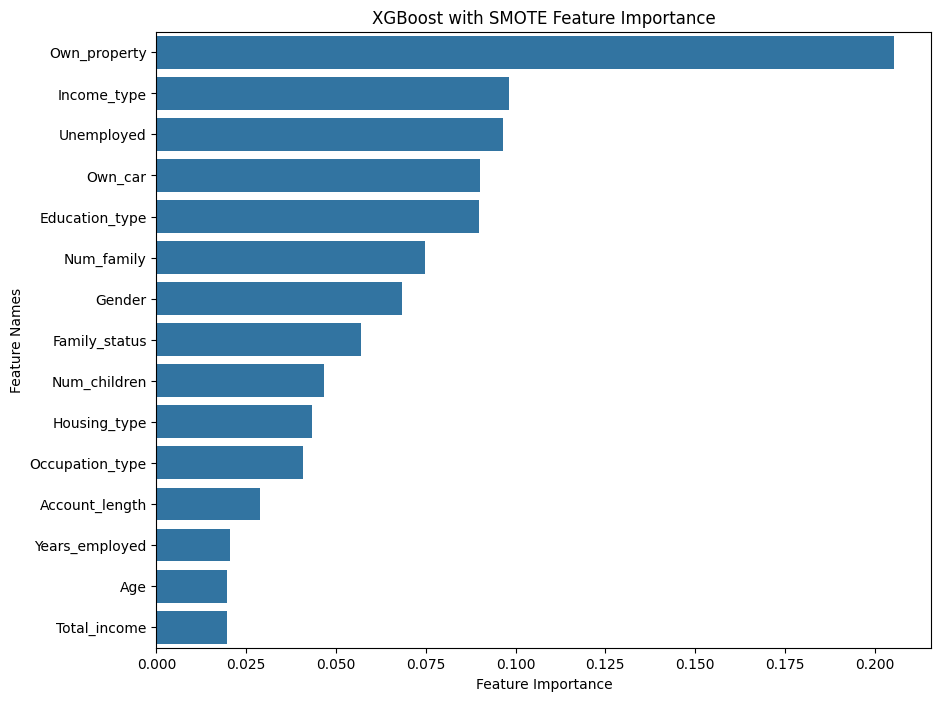

In [138]:
# Create a function that plots the feature importance
def plot_feature_importance(importance, names, model_type):
	feature_importance = np.array(importance)
	feature_names = np.array(names)

	data={'feature_names':feature_names,'feature_importance':feature_importance}
	fi_df = pd.DataFrame(data)

	fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

	plt.figure(figsize=(10,8))
	sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
	plt.title(model_type + ' Feature Importance')
	plt.xlabel('Feature Importance')
	plt.ylabel('Feature Names')

plot_feature_importance(xgb_smote.feature_importances_, X.columns, 'XGBoost with SMOTE')

In [139]:
# Get top 8 features
top_features = X.columns[xgb_smote.feature_importances_.argsort()[::-1][:8]]
print(top_features)

Index(['Own_property', 'Income_type', 'Unemployed', 'Own_car',
       'Education_type', 'Num_family', 'Gender', 'Family_status'],
      dtype='object')


In [146]:
# SMOTE
xgb_smote_top_feat = train_with_imblearn(xgb_model, X_train_smote[top_features], y_train_smote, X_val[top_features], y_val, 'SMOTE')

# Borderline SMOTE
xgb_borderline_top_feat = train_with_imblearn(xgb_model, X_train_borderline_smote[top_features], y_train_borderline_smote, X_val[top_features], y_val, 'Borderline SMOTE')

# SVM SMOTE
xgb_svm_top_feat = train_with_imblearn(xgb_model, X_train_svm_smote[top_features], y_train_svm_smote, X_val[top_features], y_val, 'SVM SMOTE')

# ADASYN
xgb_adasyn_top_feat = train_with_imblearn(xgb_model, X_train_adasyn[top_features], y_train_adasyn, X_val[top_features], y_val, 'ADASYN')

Validation Results of the model trained with SMOTE.
Accuracy: 0.7531589773729063
Precision: 0.8185157972079353
Recall: 0.6526069127123608
F1: 0.7262059973924381
ROC AUC: 0.7534850601297653
Validation Results of the model trained with Borderline SMOTE.
Accuracy: 0.7519835439318249
Precision: 0.8232209737827715
Recall: 0.6438195664909198
F1: 0.722550953320184
ROC AUC: 0.7523343115473466
Validation Results of the model trained with SVM SMOTE.
Accuracy: 0.7396414928004702
Precision: 0.8854460093896713
Recall: 0.552431165787932
F1: 0.6803751803751804
ROC AUC: 0.7402486017618906
Validation Results of the model trained with ADASYN.
Accuracy: 0.7513958272112842
Precision: 0.8059701492537313
Recall: 0.664323374340949
F1: 0.7283236994219653
ROC AUC: 0.7516781966044367


Based on the results shown above, we can see that the classification using top features is not better than the classification using all features.

## Cross Validation

In [166]:
# Stratified KFold Cross Validation
def get_best_fold(classifier, X_train, y_train, X_val, y_val, n_splits=10, random_state=1):
	best_fold = -1  # Initialize with an invalid fold number
	best_train_index = None
	best_val_index = None
	best_roc_auc_score = 0

	kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

	for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
		X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
		y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

		classifier.fit(X_train_fold, y_train_fold)
		y_pred = classifier.predict(X_val_fold)

		current_roc_auc_score = roc_auc_score(y_val_fold, y_pred)

		if current_roc_auc_score > best_roc_auc_score:
			best_roc_auc_score = current_roc_auc_score
			best_fold = fold  # Update the best fold number
			best_train_index = train_index
			best_val_index = val_index

	print("Best Fold: {}, Best ROC AUC: {}".format(best_fold, best_roc_auc_score))
	
	# Extract the train and validation set for the best fold
	X_train_best = X_train.iloc[best_train_index]
	y_train_best = y_train.iloc[best_train_index]
	X_val_best = X_train.iloc[best_val_index]
	y_val_best = y_train.iloc[best_val_index]
	
	return X_train_best, y_train_best, X_val_best, y_val_best


Validation Results of the model trained with SVM SMOTE.
Accuracy: 0.850192821121329
Precision: 0.9100968188105117
Recall: 0.7782377291543465
F1: 0.8390181702263309
ROC AUC: 0.8504283883866971


In [167]:
X_train_svm_smote, X_val, y_train_svm_smote, y_val = train_test_split(X_svm_smote, y_svm_smote, test_size=0.2, random_state=42)
xgb_svm = train_with_imblearn(xgb_model, X_train_svm_smote, y_train_svm_smote, X_val, y_val, 'SVM SMOTE')
X_train_best, y_train_best, X_val_best, y_val_best = get_best_fold(
	classifier=xgb_svm,
	X_train=X_train_svm_smote,
	y_train=y_train_svm_smote,
	X_val=X_val,
	y_val=y_val,
	n_splits=10,
	random_state=1
)

Validation Results of the model trained with SVM SMOTE.
Accuracy: 0.850192821121329
Precision: 0.9100968188105117
Recall: 0.7782377291543465
F1: 0.8390181702263309
ROC AUC: 0.8504283883866971
Best Fold: 9, Best ROC AUC: 0.8686943620178041
